# WildFire ML Project - Deep Neural Networks

### Import Modules

In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from tqdm import tqdm
from sklearn import metrics
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [19]:
# set seed
torch.cuda.manual_seed(1)
# Switch to GPU for Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Clear GPU caches
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())

### Parameters Setup

In [20]:
batch_size = 20000 # 20000
split_ratio = 0.8
learning_rate = 0.00015
epochs = 250

### Load Dataset

In [21]:
# import dataset
dataset = pd.read_csv("modeling_data.csv")
print(dataset.columns)
# get x and y
x = dataset[['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency',"burned_area_mom","burned_area_yoy","lat","month"]]
y = dataset["burned_area"]
# convert to numpy
x = np.array(x)
y = np.array(y).reshape(-1, 1)
print(x.shape, y.shape)

Index(['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness',
       'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m',
       'climate_rain', 'human_density', 'light_frequency', 'burned_area',
       'burned_area_mom', 'burned_area_yoy', 'month', 'sequence', 'lat',
       'lon'],
      dtype='object')
(107433, 14) (107433, 1)


### Standardization / Normalization

In [22]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
x_stand = scaler_X.fit_transform(x)
y_stand = scaler_y.fit_transform(y)

### Train Test Split

In [23]:
train_x = x_stand[0:int(split_ratio*len(x_stand)),:]
train_y = y_stand[0:int(split_ratio*len(y_stand)),:]
test_x = x_stand[int(split_ratio*len(x_stand)):x_stand.shape[0],:]
test_y = y_stand[int(split_ratio*len(y_stand)):y_stand.shape[0],:]

### Define Dataset and Dataloader

In [24]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.tensor(data_inputs).float()
        self.label = torch.tensor(data_targets).float()

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.label[idx]
        return x, y

    def __len__(self):
        return len(self.label)

In [25]:
trainset = Dataset(train_x, train_y)
testset = Dataset(test_x, test_y)
TrainDataLoader = Data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=False)
TestDataLoader = Data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=False)

In [26]:
for i,(v,j) in enumerate(TrainDataLoader):
    print(v.shape,j.shape)
    break

torch.Size([20000, 14]) torch.Size([20000, 1])


### Neural Network Architecture

In [27]:
# Define the neural network
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.layer1 = nn.Linear(train_x.shape[1], train_x.shape[1]*2)
        self.layer2 = nn.Linear(train_x.shape[1]*2, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 4)
        self.layer5 = nn.Linear(4, 1)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer5(x)
  
        return x

In [28]:
net = network().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net

network(
  (layer1): Linear(in_features=14, out_features=28, bias=True)
  (layer2): Linear(in_features=28, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=4, bias=True)
  (layer5): Linear(in_features=4, out_features=1, bias=True)
  (activation): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

### Training

In [29]:
# metrics lists
train_loss_history = []
train_r2_history = []
val_loss_history = []
val_r2_history = []
val_rho_history = []

In [30]:
# Perform iterations
for epoch in tqdm(range(epochs), desc='Training'):
    # create lists
    train_loss_lst = []
    train_r2_lst = []
    val_loss_lst = []
    val_r2_lst = []
    val_rho_lst = []
    
    
    # ====== Training Mode ======
    net.train()
    for (x_input, y_true) in TrainDataLoader:
        # attach to GPU
        x_input = x_input.to(device)
        y_true = y_true.to(device)
        # gain outputs
        outputs = net(x_input)
        # compute loss
        loss = criterion(outputs, y_true)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # r2 = r_squared(y_true, outputs)
        r2 = metrics.r2_score(y_true.detach().cpu().numpy().squeeze(),outputs.detach().cpu().numpy().squeeze())
        # append results
        train_loss_lst.append(loss.item())
        train_r2_lst.append(r2)
    # Append the performance result after each epoch
    best_perform = train_r2_lst.index(max(train_r2_lst))
    train_loss_history.append(train_loss_lst[best_perform])
    train_r2_history.append(train_r2_lst[best_perform])
    # ====== Training Mode End ======
    
    
    # ====== Testing Mode ======
    net.eval()
    for (x_val_input, y_val_input) in TestDataLoader:
        # attach to GPU
        x_val_input = x_val_input.to(device)
        y_val_input = y_val_input.to(device)
        # gain outputs
        outputs = net(x_val_input)
        # compute loss
        loss = criterion(outputs, y_val_input)
        # r2 = r_squared(y_val_input, outputs) & Rho
        r2 = metrics.r2_score(y_val_input.detach().cpu().numpy().squeeze(),outputs.detach().cpu().numpy().squeeze())
        rho = np.corrcoef(y_val_input.detach().cpu().numpy().squeeze(), outputs.detach().cpu().numpy().squeeze())[0][1]
        # append results
        val_rho_lst.append(rho)
        val_loss_lst.append(loss.item())
        val_r2_lst.append(r2)
    # Append the performance result after each epoch
    best_perform = val_r2_lst.index(max(val_r2_lst))
    val_loss_history.append(val_loss_lst[best_perform])
    val_r2_history.append(val_r2_lst[best_perform])
    val_rho_history.append(val_rho_lst[best_perform])
    # ====== Testing Mode End ======
    
    
    # output the performance every 10 times
    if str(epoch+1).endswith("0"):
        print("Current Epoch: "+str(epoch+1)+"/"+str(epochs), " | Train Loss: "+str(train_loss_history[-1]), " | Train R2: "+str(train_r2_history[-1])," | Val Loss: "+str(val_loss_history[-1])," | Val Rho: "+str(val_rho_history[-1])," | Val R2: "+str(val_r2_history[-1]))

Training:   4%|▍         | 10/250 [00:12<04:41,  1.17s/it]

Current Epoch: 10/250  | Train Loss: 0.9272680878639221  | Train R2: 0.09083509869884643  | Val Loss: 0.7629254460334778  | Val Rho: 0.8295805741501352  | Val R2: -0.42012602106826913


Training:   8%|▊         | 20/250 [00:23<04:20,  1.13s/it]

Current Epoch: 20/250  | Train Loss: 0.7813764214515686  | Train R2: 0.23917034813030968  | Val Loss: 0.5639029145240784  | Val Rho: 0.8389042485205979  | Val R2: -0.04966108383866619


Training:  12%|█▏        | 30/250 [00:34<04:04,  1.11s/it]

Current Epoch: 30/250  | Train Loss: 0.6153140664100647  | Train R2: 0.39538027596049397  | Val Loss: 0.3834443688392639  | Val Rho: 0.8287203098837932  | Val R2: 0.28624833479347445


Training:  16%|█▌        | 40/250 [00:45<03:56,  1.13s/it]

Current Epoch: 40/250  | Train Loss: 0.4927893877029419  | Train R2: 0.5163499936724874  | Val Loss: 0.29738572239875793  | Val Rho: 0.8140926108997277  | Val R2: 0.44643969905373304


Training:  20%|██        | 50/250 [00:56<03:42,  1.11s/it]

Current Epoch: 50/250  | Train Loss: 0.41826286911964417  | Train R2: 0.5891794736191125  | Val Loss: 0.256697416305542  | Val Rho: 0.8053538028349668  | Val R2: 0.5221778696984523


Training:  24%|██▍       | 60/250 [01:08<03:34,  1.13s/it]

Current Epoch: 60/250  | Train Loss: 0.37136054039001465  | Train R2: 0.6341025454383588  | Val Loss: 0.23220199346542358  | Val Rho: 0.8010476161827365  | Val R2: 0.5677741775407791


Training:  28%|██▊       | 70/250 [01:18<03:11,  1.07s/it]

Current Epoch: 70/250  | Train Loss: 0.35055649280548096  | Train R2: 0.6608155741486548  | Val Loss: 0.21753446757793427  | Val Rho: 0.7980083762613253  | Val R2: 0.595076587848602


Training:  32%|███▏      | 80/250 [01:29<02:59,  1.06s/it]

Current Epoch: 80/250  | Train Loss: 0.3424771726131439  | Train R2: 0.6680764040595627  | Val Loss: 0.20817485451698303  | Val Rho: 0.7973750040991981  | Val R2: 0.6124988241863049


Training:  36%|███▌      | 90/250 [01:40<02:49,  1.06s/it]

Current Epoch: 90/250  | Train Loss: 0.33177900314331055  | Train R2: 0.6829095182893083  | Val Loss: 0.20248310267925262  | Val Rho: 0.7978256119935027  | Val R2: 0.6230935388134395


Training:  40%|████      | 100/250 [01:51<02:45,  1.10s/it]

Current Epoch: 100/250  | Train Loss: 0.3290594220161438  | Train R2: 0.6794169602509326  | Val Loss: 0.1978399157524109  | Val Rho: 0.800036874950669  | Val R2: 0.6317364827517933


Training:  44%|████▍     | 110/250 [02:02<02:33,  1.10s/it]

Current Epoch: 110/250  | Train Loss: 0.3246857225894928  | Train R2: 0.6856196272268607  | Val Loss: 0.1943451315164566  | Val Rho: 0.8024582860981857  | Val R2: 0.6382417241149324


Training:  48%|████▊     | 120/250 [02:13<02:14,  1.04s/it]

Current Epoch: 120/250  | Train Loss: 0.3232284188270569  | Train R2: 0.6864635474910848  | Val Loss: 0.19088301062583923  | Val Rho: 0.8055804061082968  | Val R2: 0.6446861994873067


Training:  52%|█████▏    | 130/250 [02:24<02:14,  1.12s/it]

Current Epoch: 130/250  | Train Loss: 0.3182491660118103  | Train R2: 0.6905311852854967  | Val Loss: 0.1879403293132782  | Val Rho: 0.8085629107308503  | Val R2: 0.6501638035447697


Training:  56%|█████▌    | 140/250 [02:34<01:50,  1.00s/it]

Current Epoch: 140/250  | Train Loss: 0.31089478731155396  | Train R2: 0.6927499123019686  | Val Loss: 0.1851842850446701  | Val Rho: 0.8116802816130975  | Val R2: 0.6552939386650061


Training:  60%|██████    | 150/250 [02:44<01:40,  1.00s/it]

Current Epoch: 150/250  | Train Loss: 0.30790334939956665  | Train R2: 0.6971957417949682  | Val Loss: 0.1822729855775833  | Val Rho: 0.8149015821447427  | Val R2: 0.6607131129155913


Training:  64%|██████▍   | 160/250 [02:54<01:34,  1.05s/it]

Current Epoch: 160/250  | Train Loss: 0.30598583817481995  | Train R2: 0.7022357585277688  | Val Loss: 0.17990070581436157  | Val Rho: 0.8177043310448341  | Val R2: 0.6651289154905919


Training:  68%|██████▊   | 170/250 [03:04<01:17,  1.03it/s]

Current Epoch: 170/250  | Train Loss: 0.30427905917167664  | Train R2: 0.7013319385429392  | Val Loss: 0.1773785650730133  | Val Rho: 0.8206481448983293  | Val R2: 0.6698237026906826


Training:  72%|███████▏  | 180/250 [03:14<01:10,  1.01s/it]

Current Epoch: 180/250  | Train Loss: 0.31195536255836487  | Train R2: 0.7024344885162142  | Val Loss: 0.17513442039489746  | Val Rho: 0.823360344065121  | Val R2: 0.6740009937142886


Training:  76%|███████▌  | 190/250 [03:24<00:57,  1.04it/s]

Current Epoch: 190/250  | Train Loss: 0.3070983588695526  | Train R2: 0.702491426393873  | Val Loss: 0.1728115975856781  | Val Rho: 0.8261050533225752  | Val R2: 0.6783247541858775


Training:  80%|████████  | 200/250 [03:33<00:48,  1.03it/s]

Current Epoch: 200/250  | Train Loss: 0.29804930090904236  | Train R2: 0.7084005247829147  | Val Loss: 0.17078658938407898  | Val Rho: 0.8285578975232623  | Val R2: 0.6820941125953638


Training:  84%|████████▍ | 210/250 [03:43<00:38,  1.03it/s]

Current Epoch: 210/250  | Train Loss: 0.29963186383247375  | Train R2: 0.7065162635498705  | Val Loss: 0.16851572692394257  | Val Rho: 0.8310546701158633  | Val R2: 0.6863211465244909


Training:  88%|████████▊ | 220/250 [03:53<00:28,  1.04it/s]

Current Epoch: 220/250  | Train Loss: 0.2967234253883362  | Train R2: 0.7096543100511896  | Val Loss: 0.16639955341815948  | Val Rho: 0.8334946456569371  | Val R2: 0.6902602492290395


Training:  92%|█████████▏| 230/250 [04:03<00:19,  1.03it/s]

Current Epoch: 230/250  | Train Loss: 0.2971254289150238  | Train R2: 0.7109752728346437  | Val Loss: 0.1644531935453415  | Val Rho: 0.8359587000890271  | Val R2: 0.6938832374637385


Training:  96%|█████████▌| 240/250 [04:12<00:09,  1.04it/s]

Current Epoch: 240/250  | Train Loss: 0.29307207465171814  | Train R2: 0.7152753322564795  | Val Loss: 0.16207344830036163  | Val Rho: 0.8385194995690417  | Val R2: 0.6983129654329128


Training: 100%|██████████| 250/250 [04:22<00:00,  1.05s/it]

Current Epoch: 250/250  | Train Loss: 0.2935499846935272  | Train R2: 0.7124589602750826  | Val Loss: 0.16017307341098785  | Val Rho: 0.8407081673291418  | Val R2: 0.7018503779099037


### Save model parameters

In [31]:
# Save Model Path
path = "WildFire Prediction.pth"
torch.save(net.state_dict(),path)
print("Model saved to local disk.")

evaluation = pd.DataFrame(columns = ["train loss","train accuracy","validation loss","validation accuracy","validation Rho"])
evaluation["train loss"] =train_loss_history
evaluation["train accuracy"] =train_r2_history
evaluation["validation loss"] =val_loss_history
evaluation["validation accuracy"] = val_r2_history
evaluation["validation Rho"] = val_rho_history
evaluation.to_csv("model_evaluation.csv",index=False)
print("Evaluation Metrics saved to local disk.")

Model saved to local disk.
Evaluation Metrics saved to local disk.


### Model Performance Check

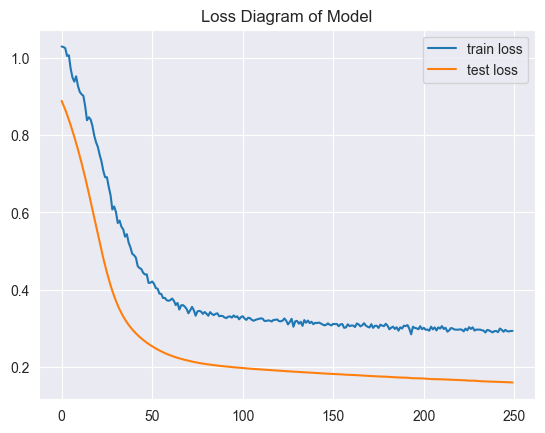

In [32]:
plt.plot(train_loss_history, label = "train loss")
plt.plot(val_loss_history, label = "test loss")
plt.title("Loss Diagram of Model")
plt.legend()

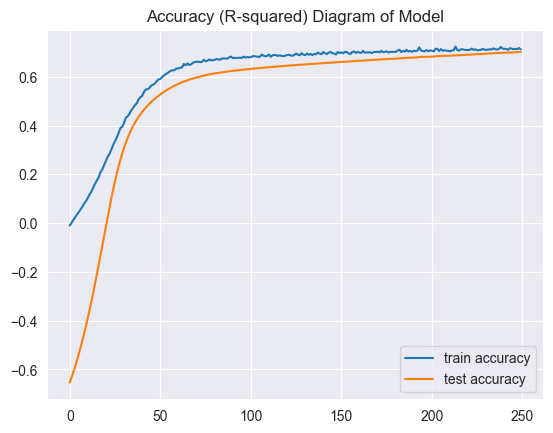

In [33]:
plt.plot(train_r2_history, label = "train accuracy")
plt.plot(val_r2_history, label = "test accuracy")
plt.title("Accuracy (R-squared) Diagram of Model")
plt.legend()

Text(0.5, 1.0, 'Correlation between prediction & true burned area')

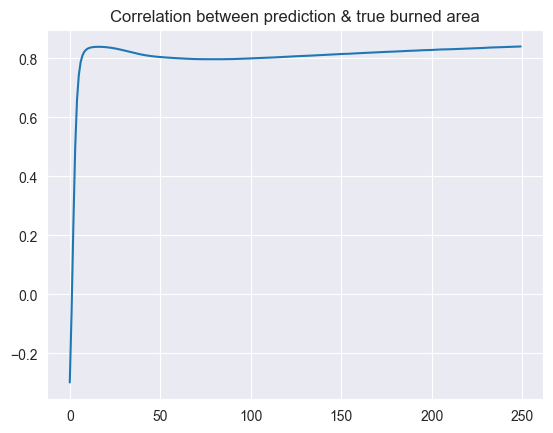

In [34]:
plt.plot(val_rho_history)
plt.title("Correlation between prediction & true burned area")